# Futures Data Processing Walkthrough

This notebook demonstrates the data processing pipeline for equity index futures data, which is a critical component of our equity spot-futures arbitrage analysis project.

## Project Context: Equity Spot-Futures Arbitrage

Our project analyzes arbitrage opportunities between equity spot and futures markets, focusing on three major indices:
- S&P 500 (SPX with ES futures)
- Nasdaq 100 (NDX with NQ futures)
- Dow Jones Industrial Average (INDU with DM futures)

To calculate implied forward rates for arbitrage analysis, we need properly processed futures data with accurate settlement dates and time-to-maturity calculations.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import logging
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set_style('whitegrid')

# Add the src directory to the path to import our settings
sys.path.insert(1, "./src")
try:
    from settings import config
    print("Successfully imported config from settings module")
except ImportError:
    print("Failed to import config. Make sure your working directory is set correctly.")
    def config(key):
        config_dict = {
            "DATA_DIR": Path("./_data"),
            "TEMP_DIR": Path("./_data/temp"),
            "INPUT_DIR": Path("./_data/input"),
            "PROCESSED_DIR": Path("./_data/processed"),
            "MANUAL_DATA_DIR": Path("./data_manual"),
            "OUTPUT_DIR":Path("./_output"),
        }
        return config_dict.get(key, Path("./data"))

Successfully imported config from settings module


## Load Libraries 

In [2]:
# Load configuration paths
DATA_DIR = config("DATA_DIR")
TEMP_DIR = config("TEMP_DIR")
INPUT_DIR = config("INPUT_DIR")
PROCESSED_DIR = config("PROCESSED_DIR")
DATA_MANUAL = config("MANUAL_DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")

# Create directories if they don't exist
for dir_path in [DATA_DIR, TEMP_DIR, INPUT_DIR, PROCESSED_DIR, DATA_MANUAL]:
    os.makedirs(dir_path, exist_ok=True)

# Set up logging
log_file = TEMP_DIR / 'futures_processing_notebook.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)
logger.info("Logging configured successfully")
logger.info(f"Log file will be saved to: {log_file}")

2025-03-11 04:10:26,143 - INFO - Logging configured successfully


2025-03-11 04:10:26,144 - INFO - Log file will be saved to: C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\_output\temp\futures_processing_notebook.log


## Define Utility Functions
We need several utility functions to properly process futures contract data:

In [3]:
def get_third_friday(year, month):
    """
    Calculate the third Friday of a given month and year.
    
    Args:
        year (int): Year
        month (int): Month (1-12)
        
    Returns:
        datetime: Date object for the third Friday
    """
    # Use calendar.monthcalendar: each week is a list of ints (0 if day not in month)
    month_cal = calendar.monthcalendar(year, month)
    # The first week that has a Friday (weekday index 4)
    fridays = [week[calendar.FRIDAY] for week in month_cal if week[calendar.FRIDAY] != 0]
    if len(fridays) < 3:
        raise ValueError(f"Not enough Fridays in {year}-{month}")
    return datetime(year, month, fridays[2])  # third Friday

def parse_contract_month_year(contract_str):
    """
    Parse Bloomberg's contract month/year string (e.g., 'DEC 10') into
    a month number and a full year.
    
    Args:
        contract_str (str): Contract month/year string
        
    Returns:
        tuple: (month_num, year_full) or (None, None) if invalid.
    """
    if pd.isna(contract_str) or contract_str.strip() == '':
        return None, None
    parts = contract_str.split()
    if len(parts) != 2:
        logger.warning(f"Unexpected contract format: {contract_str}")
        return None, None
    month_abbr, year_abbr = parts
    allowed = {"MAR": 3, "JUN": 6, "SEP": 9, "DEC": 12}
    if month_abbr.upper() not in allowed:
        raise ValueError(f"Contract month {month_abbr} not in allowed set {list(allowed.keys())}")
    month_num = allowed[month_abbr.upper()]
    try:
        yr = int(year_abbr)
        year_full = 2000 + yr if yr < 50 else 1900 + yr
    except ValueError:
        logger.warning(f"Could not parse year: {year_abbr}")
        return None, None
    return month_num, year_full

# Test our utility functions with a couple of examples
print(f"Third Friday of March 2023: {get_third_friday(2023, 3)}")
print(f"Parsing 'DEC 22': {parse_contract_month_year('DEC 22')}")
print(f"Parsing 'MAR 23': {parse_contract_month_year('MAR 23')}")

Third Friday of March 2023: 2023-03-17 00:00:00
Parsing 'DEC 22': (12, 2022)
Parsing 'MAR 23': (3, 2023)


## Load Bloomberg Data

Let's load the Bloomberg futures data from the Parquet file:

In [4]:
try:
    INPUT_FILE = INPUT_DIR / "bloomberg_historical_data.parquet"
    if not os.path.exists(INPUT_FILE):
        logger.warning("Primary input file not found, switching to cached data")
        INPUT_FILE = DATA_MANUAL / "bloomberg_historical_data.parquet"
    
    raw_data = pd.read_parquet(INPUT_FILE)
    logger.info(f"Successfully loaded data from {INPUT_FILE}")
    
    # Convert index to DatetimeIndex if it's not already
    if not isinstance(raw_data.index, pd.DatetimeIndex):
        raw_data.index = pd.to_datetime(raw_data.index)
        logger.info("Converted index to DatetimeIndex")
    
    # Display the column structure (MultiIndex)
    logger.info(f"Column levels: {raw_data.columns.names}")
    print("\nSample of MultiIndex columns:")
    for i, col in enumerate(raw_data.columns[:10]):
        print(f"  {col}")
    print(f"  ...and {len(raw_data.columns)-10} more columns")
    
    # Display basic info about the dataset
    print(f"\nDataset shape: {raw_data.shape}")
    print(f"Date range: {raw_data.index.min()} to {raw_data.index.max()}")
    
except Exception as e:
    logger.error(f"Error loading data: {e}")
    raise

2025-03-11 04:10:26,229 - WARNING - Primary input file not found, switching to cached data


2025-03-11 04:10:26,437 - INFO - Successfully loaded data from C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\data_manual\bloomberg_historical_data.parquet


2025-03-11 04:10:26,440 - INFO - Column levels: [None, None]



Sample of MultiIndex columns:
  ('SPX Index', 'PX_LAST')
  ('SPX Index', 'IDX_EST_DVD_YLD')
  ('SPX Index', 'INDX_GROSS_DAILY_DIV')
  ('NDX Index', 'PX_LAST')
  ('NDX Index', 'IDX_EST_DVD_YLD')
  ('NDX Index', 'INDX_GROSS_DAILY_DIV')
  ('INDU Index', 'PX_LAST')
  ('INDU Index', 'IDX_EST_DVD_YLD')
  ('INDU Index', 'INDX_GROSS_DAILY_DIV')
  ('ES1 Index', 'PX_LAST')
  ...and 52 more columns

Dataset shape: (3913, 62)
Date range: 2010-01-01 00:00:00 to 2024-12-31 00:00:00


## Define Index Futures Mapping

Let's define the mapping between equity indices and their futures contracts:

In [5]:
indices = {
    'SPX': ['ES1', 'ES2', 'ES3', 'ES4'],  # S&P 500 futures
    'NDX': ['NQ1', 'NQ2', 'NQ3', 'NQ4'],  # Nasdaq 100 futures
    'INDU': ['DM1', 'DM2', 'DM3', 'DM4']  # Dow Jones futures
}

print("Equity indices and their futures contracts:")
for index, futures in indices.items():
    print(f"  {index}: {', '.join(futures)}")

Equity indices and their futures contracts:
  SPX: ES1, ES2, ES3, ES4
  NDX: NQ1, NQ2, NQ3, NQ4
  INDU: DM1, DM2, DM3, DM4


## Process Futures Data

Now, let's implement the function that processes futures data for a single index:

In [6]:
def process_index_futures(data, futures_codes):
    """
    Process futures data for one index.
    
    Args:
        data (pd.DataFrame): Multi-index DataFrame with Bloomberg data (indexed by Date)
        futures_codes (list): List of futures codes (e.g., ['ES1', 'ES2', ...])
        
    Returns:
        dict: Dictionary of processed DataFrames, one for each futures code.
              Each DataFrame contains:
                  - Date
                  - Futures_Price (from PX_LAST)
                  - Volume, OpenInterest (if available)
                  - ContractSpec (raw CURRENT_CONTRACT_MONTH_YR)
                  - SettlementDate (actual settlement, 3rd Friday)
                  - TTM (time-to-maturity in days)
    """
    result_dfs = {}
    for code in futures_codes:
        logger.info(f"Processing futures data for {code} Index")
        try:
            # Extract columns for this contract
            price_series = data.loc[:, (f'{code} Index', 'PX_LAST')]
            volume_series = data.loc[:, (f'{code} Index', 'PX_VOLUME')]
            oi_series = data.loc[:, (f'{code} Index', 'OPEN_INT')]
            contract_series = data.loc[:, (f'{code} Index', 'CURRENT_CONTRACT_MONTH_YR')]
            
            # Create a DataFrame for this contract; index is Date (from raw data)
            df_contract = pd.DataFrame({
                'Date': data.index,
                'Futures_Price': price_series,
                'Volume': volume_series,
                'OpenInterest': oi_series,
                'ContractSpec': contract_series
            })
            df_contract = df_contract.reset_index(drop=True)
            
            # Parse contract specification and compute settlement date
            settlement_dates = []
            for cs in df_contract['ContractSpec']:
                month_num, year_full = parse_contract_month_year(cs)
                if month_num is None or year_full is None:
                    settlement_dates.append(None)
                else:
                    settlement_dates.append(get_third_friday(year_full, month_num))
            df_contract['SettlementDate'] = pd.to_datetime(settlement_dates)
            
            # Compute TTM in days: SettlementDate - Date
            df_contract['Date'] = pd.to_datetime(df_contract['Date'])
            df_contract['TTM'] = (df_contract['SettlementDate'] - df_contract['Date']).dt.days
            
            # Drop rows with missing TTM (if settlement date couldn't be computed)
            df_contract = df_contract.dropna(subset=['TTM'])
            result_dfs[code] = df_contract
            logger.info(f"Processed {code}: {len(df_contract)} rows")
        except Exception as e:
            logger.error(f"Error processing {code}: {e}")
            continue
    return result_dfs

## Process All Indices

Let's apply our processing function to all indices:

In [7]:
all_futures = {}
for index_code, futures_codes in indices.items():
    logger.info(f"Processing futures for index {index_code}")
    processed = process_index_futures(raw_data, futures_codes)
    all_futures[index_code] = processed
    
    # Display a sample of the processed data for each index
    print(f"\nProcessed Futures for {index_code}:")
    for code, df in processed.items():
        print(f"  {code} - Shape: {df.shape}")
        display(df.head(3))

2025-03-11 04:10:26,567 - INFO - Processing futures for index SPX


2025-03-11 04:10:26,571 - INFO - Processing futures data for ES1 Index


2025-03-11 04:10:26,729 - INFO - Processed ES1: 3781 rows


2025-03-11 04:10:26,731 - INFO - Processing futures data for ES2 Index


2025-03-11 04:10:26,871 - INFO - Processed ES2: 3781 rows


2025-03-11 04:10:26,876 - INFO - Processing futures data for ES3 Index


2025-03-11 04:10:27,017 - INFO - Processed ES3: 3781 rows


2025-03-11 04:10:27,021 - INFO - Processing futures data for ES4 Index


2025-03-11 04:10:27,158 - INFO - Processed ES4: 3781 rows



Processed Futures for SPX:
  ES1 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1128.75,1282633.0,2440458.0,MAR 10,2010-03-19,74.0
2,2010-01-05,1132.25,1368386.0,2402850.0,MAR 10,2010-03-19,73.0
3,2010-01-06,1133.00,1252015.0,2396493.0,MAR 10,2010-03-19,72.0


  ES2 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1124.0,1641.0,3354.0,JUN 10,2010-06-18,165.0
2,2010-01-05,1127.5,686.0,3432.0,JUN 10,2010-06-18,164.0
3,2010-01-06,1128.0,1163.0,3713.0,JUN 10,2010-06-18,163.0


  ES3 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1119.5,100.0,439.0,SEP 10,2010-09-17,256.0
2,2010-01-05,1123.0,300.0,539.0,SEP 10,2010-09-17,255.0
3,2010-01-06,1123.5,601.0,1140.0,SEP 10,2010-09-17,254.0


  ES4 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1116.5,NaN,6.0,DEC 10,2010-12-17,347.0
2,2010-01-05,1120.0,4.0,8.0,DEC 10,2010-12-17,346.0
3,2010-01-06,1120.5,NaN,8.0,DEC 10,2010-12-17,345.0


2025-03-11 04:10:27,244 - INFO - Processing futures for index NDX


2025-03-11 04:10:27,251 - INFO - Processing futures data for NQ1 Index


2025-03-11 04:10:27,394 - INFO - Processed NQ1: 3781 rows


2025-03-11 04:10:27,398 - INFO - Processing futures data for NQ2 Index


2025-03-11 04:10:27,554 - INFO - Processed NQ2: 3781 rows


2025-03-11 04:10:27,560 - INFO - Processing futures data for NQ3 Index


2025-03-11 04:10:27,714 - INFO - Processed NQ3: 3781 rows


2025-03-11 04:10:27,718 - INFO - Processing futures data for NQ4 Index


2025-03-11 04:10:27,869 - INFO - Processed NQ4: 3781 rows



Processed Futures for NDX:
  NQ1 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1886.75,204140.0,314877.0,MAR 10,2010-03-19,74.0
2,2010-01-05,1885.25,207245.0,309080.0,MAR 10,2010-03-19,73.0
3,2010-01-06,1878.50,259627.0,310532.0,MAR 10,2010-03-19,72.0


  NQ2 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1884.75,33.0,671.0,JUN 10,2010-06-18,165.0
2,2010-01-05,1883.00,74.0,651.0,JUN 10,2010-06-18,164.0
3,2010-01-06,1876.50,33.0,665.0,JUN 10,2010-06-18,163.0


  NQ3 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1883.75,NaN,NaN,SEP 10,2010-09-17,256.0
2,2010-01-05,1882.00,NaN,NaN,SEP 10,2010-09-17,255.0
3,2010-01-06,1875.50,NaN,NaN,SEP 10,2010-09-17,254.0


  NQ4 - Shape: (3781, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,1882.75,NaN,2.0,DEC 10,2010-12-17,347.0
2,2010-01-05,1881.00,NaN,2.0,DEC 10,2010-12-17,346.0
3,2010-01-06,1874.50,NaN,2.0,DEC 10,2010-12-17,345.0


2025-03-11 04:10:27,959 - INFO - Processing futures for index INDU


2025-03-11 04:10:27,961 - INFO - Processing futures data for DM1 Index


2025-03-11 04:10:28,110 - INFO - Processed DM1: 3780 rows


2025-03-11 04:10:28,111 - INFO - Processing futures data for DM2 Index


2025-03-11 04:10:28,252 - INFO - Processed DM2: 3780 rows


2025-03-11 04:10:28,255 - INFO - Processing futures data for DM3 Index


2025-03-11 04:10:28,430 - INFO - Processed DM3: 3780 rows


2025-03-11 04:10:28,435 - INFO - Processing futures data for DM4 Index


2025-03-11 04:10:28,591 - INFO - Processed DM4: 3780 rows



Processed Futures for INDU:
  DM1 - Shape: (3780, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,10519.0,93770.0,69420.0,MAR 10,2010-03-19,74.0
2,2010-01-05,10515.0,93287.0,65749.0,MAR 10,2010-03-19,73.0
3,2010-01-06,10516.0,97172.0,63888.0,MAR 10,2010-03-19,72.0


  DM2 - Shape: (3780, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,10459.0,100.0,175.0,JUN 10,2010-06-18,165.0
2,2010-01-05,10455.0,26.0,173.0,JUN 10,2010-06-18,164.0
3,2010-01-06,10455.0,157.0,193.0,JUN 10,2010-06-18,163.0


  DM3 - Shape: (3780, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,10404.0,NaN,1.0,SEP 10,2010-09-17,256.0
2,2010-01-05,10400.0,NaN,1.0,SEP 10,2010-09-17,255.0
3,2010-01-06,10400.0,NaN,2.0,SEP 10,2010-09-17,254.0


  DM4 - Shape: (3780, 7)


,Date,Futures_Price,Volume,OpenInterest,ContractSpec,SettlementDate,TTM
1,2010-01-04,10354.0,NaN,NaN,DEC 10,2010-12-17,347.0
2,2010-01-05,10350.0,NaN,NaN,DEC 10,2010-12-17,346.0
3,2010-01-06,10351.0,NaN,NaN,DEC 10,2010-12-17,345.0


## Analyze Contract Roll Patterns

Let's visualize how contracts roll over time for one of the indices:

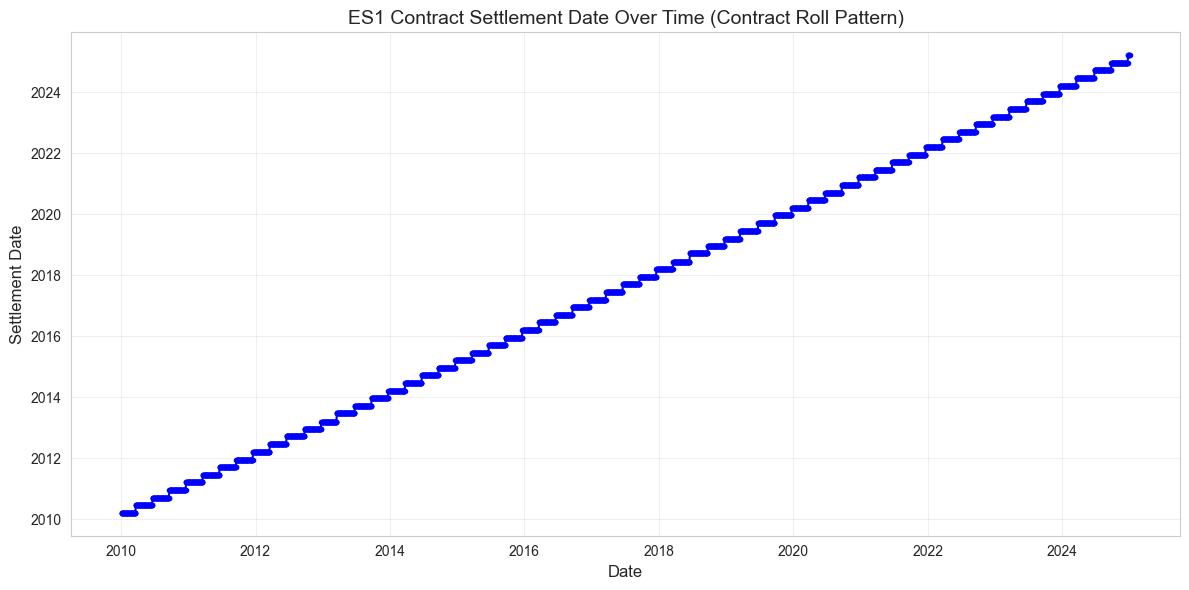

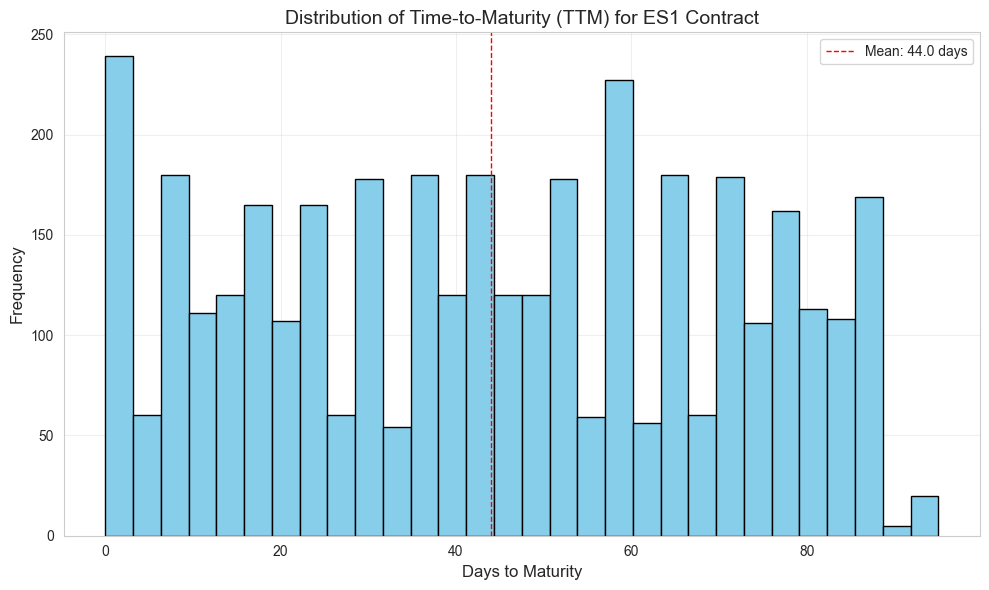

In [8]:
# Choose SPX ES1 (front-month) contract for visualization
es1_df = all_futures['SPX']['ES1']

# Plot settlement date changes over time to visualize contract rolls
plt.figure(figsize=(12, 6))
plt.plot(es1_df['Date'], es1_df['SettlementDate'], 'b.-')
plt.title('ES1 Contract Settlement Date Over Time (Contract Roll Pattern)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Settlement Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the visualization
plt.savefig(OUTPUT_DIR / 'es1_contract_roll_pattern.png', dpi=300)
plt.show()

# Analyze TTM distribution for ES1
plt.figure(figsize=(10, 6))
plt.hist(es1_df['TTM'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(es1_df['TTM'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {es1_df["TTM"].mean():.1f} days')
plt.title('Distribution of Time-to-Maturity (TTM) for ES1 Contract', fontsize=14)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Save the visualization
plt.savefig(OUTPUT_DIR / 'es1_ttm_distribution.png', dpi=300)
plt.show()

## Create Calendar Spreads

Now let's implement the function to merge the Term 1 (nearest) and Term 2 (next nearest) contracts to create calendar spreads:

In [9]:
def merge_calendar_spreads(all_futures):
    """
    For each index, merge the processed data for the two nearest futures contracts (Term 1 and Term 2)
    on the Date field, and then combine the calendar spreads for all indices.
    
    Args:
        all_futures (dict): Dictionary keyed by index code (e.g., 'SPX', 'NDX', 'INDU') where the value is
                            another dictionary mapping futures code to its processed DataFrame.
                            
    Returns:
        pd.DataFrame: Combined calendar spread data for all indices.
    """
    combined = []
    # For each index, the first two codes are the two nearest contracts.
    for index_code, fut_dict in all_futures.items():
        # Identify term1 and term2 codes:
        codes = list(fut_dict.keys())
        if len(codes) < 2:
            logger.warning(f"Not enough futures data for {index_code}")
            continue
        term1 = fut_dict[codes[0]].copy()
        term2 = fut_dict[codes[1]].copy()
        # Add a prefix so that we can merge and distinguish columns:
        term1 = term1.add_prefix('Term1_')
        term2 = term2.add_prefix('Term2_')
        # Rename the Date columns back to 'Date' for merging
        term1.rename(columns={'Term1_Date': 'Date'}, inplace=True)
        term2.rename(columns={'Term2_Date': 'Date'}, inplace=True)
        merged = pd.merge(term1, term2, on='Date', how='inner')
        merged['Index'] = index_code
        combined.append(merged)
    if combined:
        combined_df = pd.concat(combined, ignore_index=True)
        return combined_df
    else:
        logger.warning("No valid calendar spread data to combine")
        return None

## Create and Analyze Calendar Spreads

Let's apply the function to create calendar spreads and analyze the results:

In [10]:
# Create calendar spreads
combined_spreads = merge_calendar_spreads(all_futures)

# Display a sample of the calendar spread data
print("Sample of Combined Calendar Spread Data:")
display(combined_spreads.head())

# Check key statistics for calendar spreads
print("\nCalendar Spread Statistics by Index:")
for index in combined_spreads['Index'].unique():
    index_df = combined_spreads[combined_spreads['Index'] == index]
    print(f"\n{index} Index:")
    print(f"  Number of observations: {len(index_df)}")
    print(f"  Average Term1 TTM: {index_df['Term1_TTM'].mean():.2f} days")
    print(f"  Average Term2 TTM: {index_df['Term2_TTM'].mean():.2f} days")
    print(f"  Average calendar spread (TTM2 - TTM1): {(index_df['Term2_TTM'] - index_df['Term1_TTM']).mean():.2f} days")

Sample of Combined Calendar Spread Data:


,Date,Term1_Futures_Price,Term1_Volume,Term1_OpenInterest,Term1_ContractSpec,Term1_SettlementDate,Term1_TTM,Term2_Futures_Price,Term2_Volume,Term2_OpenInterest,Term2_ContractSpec,Term2_SettlementDate,Term2_TTM,Index
0,2010-01-04,1128.75,1282633.0,2440458.0,MAR 10,2010-03-19,74.0,1124.00,1641.0,3354.0,JUN 10,2010-06-18,165.0,SPX
1,2010-01-05,1132.25,1368386.0,2402850.0,MAR 10,2010-03-19,73.0,1127.50,686.0,3432.0,JUN 10,2010-06-18,164.0,SPX
2,2010-01-06,1133.00,1252015.0,2396493.0,MAR 10,2010-03-19,72.0,1128.00,1163.0,3713.0,JUN 10,2010-06-18,163.0,SPX
3,2010-01-07,1137.50,1553963.0,2406352.0,MAR 10,2010-03-19,71.0,1132.50,1135.0,4154.0,JUN 10,2010-06-18,162.0,SPX
4,2010-01-08,1141.50,1508175.0,2758348.0,MAR 10,2010-03-19,70.0,1136.75,1080.0,17466.0,JUN 10,2010-06-18,161.0,SPX



Calendar Spread Statistics by Index:

SPX Index:
  Number of observations: 3781
  Average Term1 TTM: 44.01 days
  Average Term2 TTM: 135.33 days
  Average calendar spread (TTM2 - TTM1): 91.32 days

NDX Index:
  Number of observations: 3781
  Average Term1 TTM: 44.01 days
  Average Term2 TTM: 135.33 days
  Average calendar spread (TTM2 - TTM1): 91.32 days

INDU Index:
  Number of observations: 3780
  Average Term1 TTM: 44.01 days
  Average Term2 TTM: 135.32 days
  Average calendar spread (TTM2 - TTM1): 91.32 days


It makes sense that the average calendar spread is over 3 months between contract 1 and contract 2

## Data Quality Checks

Let's perform some data quality checks on our processed futures data:

In [11]:
def check_futures_data_quality(combined_spreads):
    """
    Perform data quality checks on the processed futures data.
    """
    print("Running data quality checks on futures data...")
    tests_passed = 0
    tests_failed = 0
    
    # Test 1: Check that we have data for all three indices
    try:
        expected_indices = {'SPX', 'NDX', 'INDU'}
        actual_indices = set(combined_spreads['Index'].unique())
        assert expected_indices == actual_indices, f"Missing indices: {expected_indices - actual_indices}"
        print(f"Test 1 Passed: All three indices are present")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 1 Failed: {e}")
        tests_failed += 1
    
    # Test 2: Check that Term2_TTM > Term1_TTM for all rows
    try:
        assert all(combined_spreads['Term2_TTM'] > combined_spreads['Term1_TTM']), "Term2 TTM should always be greater than Term1 TTM"
        print(f"Test 2 Passed: Term2 TTM is always greater than Term1 TTM")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 2 Failed: {e}")
        tests_failed += 1
        
    # Test 3: Check that all TTM values are reasonable (positive and typically under 365 days)
    try:
        assert all(combined_spreads['Term1_TTM'] > 0), "Term1 TTM should be positive"
        assert all(combined_spreads['Term2_TTM'] > 0), "Term2 TTM should be positive"
        assert combined_spreads['Term1_TTM'].max() < 365, "Term1 TTM should typically be less than 365 days"
        assert combined_spreads['Term2_TTM'].max() < 730, "Term2 TTM should typically be less than 730 days"
        print(f"Test 3 Passed: TTM values are within reasonable ranges")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 3 Failed: {e}")
        tests_failed += 1
    
    # Test 4: Check for missing values in critical columns
    critical_columns = ['Term1_Futures_Price', 'Term2_Futures_Price', 'Term1_TTM', 'Term2_TTM']
    try:
        for col in critical_columns:
            assert combined_spreads[col].isna().sum() == 0, f"Missing values in {col}"
        print(f"Test 4 Passed: No missing values in critical columns")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 4 Failed: {e}")
        tests_failed += 1
    
    # Test 5: Check that futures prices are positive
    try:
        assert all(combined_spreads['Term1_Futures_Price'] > 0), "Term1 futures prices should be positive"
        assert all(combined_spreads['Term2_Futures_Price'] > 0), "Term2 futures prices should be positive"
        print(f"Test 5 Passed: All futures prices are positive")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 5 Failed: {e}")
        tests_failed += 1
    
    print(f"\nData quality checks complete: {tests_passed} passed, {tests_failed} failed")
    return tests_passed, tests_failed

# Run the data quality checks
tests_passed, tests_failed = check_futures_data_quality(combined_spreads)
def check_futures_data_quality(combined_spreads):
    """
    Perform data quality checks on the processed futures data.
    """
    print("Running data quality checks on futures data...")
    tests_passed = 0
    tests_failed = 0
    
    # Test 1: Check that we have data for all three indices
    try:
        expected_indices = {'SPX', 'NDX', 'INDU'}
        actual_indices = set(combined_spreads['Index'].unique())
        assert expected_indices == actual_indices, f"Missing indices: {expected_indices - actual_indices}"
        print(f"Test 1 Passed: All three indices are present")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 1 Failed: {e}")
        tests_failed += 1
    
    # Test 2: Check that Term2_TTM > Term1_TTM for all rows
    try:
        assert all(combined_spreads['Term2_TTM'] > combined_spreads['Term1_TTM']), "Term2 TTM should always be greater than Term1 TTM"
        print(f"Test 2 Passed: Term2 TTM is always greater than Term1 TTM")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 2 Failed: {e}")
        tests_failed += 1
        
    # Test 3: Check that all TTM values are reasonable (positive and typically under 365 days)
    try:
        assert all(combined_spreads['Term1_TTM'] > 0), "Term1 TTM should be positive"
        assert all(combined_spreads['Term2_TTM'] > 0), "Term2 TTM should be positive"
        assert combined_spreads['Term1_TTM'].max() < 365, "Term1 TTM should typically be less than 365 days"
        assert combined_spreads['Term2_TTM'].max() < 730, "Term2 TTM should typically be less than 730 days"
        print(f"Test 3 Passed: TTM values are within reasonable ranges")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 3 Failed: {e}")
        tests_failed += 1
    
    # Test 4: Check for missing values in critical columns
    critical_columns = ['Term1_Futures_Price', 'Term2_Futures_Price', 'Term1_TTM', 'Term2_TTM']
    try:
        for col in critical_columns:
            assert combined_spreads[col].isna().sum() == 0, f"Missing values in {col}"
        print(f"Test 4 Passed: No missing values in critical columns")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 4 Failed: {e}")
        tests_failed += 1
    
    # Test 5: Check that futures prices are positive
    try:
        assert all(combined_spreads['Term1_Futures_Price'] > 0), "Term1 futures prices should be positive"
        assert all(combined_spreads['Term2_Futures_Price'] > 0), "Term2 futures prices should be positive"
        print(f"Test 5 Passed: All futures prices are positive")
        tests_passed += 1
    except AssertionError as e:
        print(f"Test 5 Failed: {e}")
        tests_failed += 1
    
    print(f"\nData quality checks complete: {tests_passed} passed, {tests_failed} failed")
    return tests_passed, tests_failed

# Run the data quality checks
tests_passed, tests_failed = check_futures_data_quality(combined_spreads)

Running data quality checks on futures data...
Test 1 Passed: All three indices are present
Test 2 Passed: Term2 TTM is always greater than Term1 TTM
Test 3 Failed: Term1 TTM should be positive
Test 4 Passed: No missing values in critical columns
Test 5 Passed: All futures prices are positive

Data quality checks complete: 4 passed, 1 failed
Running data quality checks on futures data...
Test 1 Passed: All three indices are present
Test 2 Passed: Term2 TTM is always greater than Term1 TTM
Test 3 Failed: Term1 TTM should be positive
Test 4 Passed: No missing values in critical columns
Test 5 Passed: All futures prices are positive

Data quality checks complete: 4 passed, 1 failed


Interestingly, we do see a failed test case where TTM for Term 1 was not positive.

In [12]:
# Identify rows where Term1_TTM is not positive
problematic_rows = combined_spreads[combined_spreads['Term1_TTM'] <= 0]

# Display the count of problematic rows
print(f"Found {len(problematic_rows)} rows with non-positive Term1_TTM values")

# Display the problematic rows
if len(problematic_rows) > 0:
    print("\nRows with non-positive Term1_TTM values:")
    display(problematic_rows)
    
    # Group by index to see distribution of issues
    print("\nDistribution by index:")
    index_counts = problematic_rows['Index'].value_counts()
    display(index_counts)
    
    # Look at the date distribution
    print("\nDate range of problematic rows:")
    print(f"Earliest: {problematic_rows['Date'].min()}")
    print(f"Latest: {problematic_rows['Date'].max()}")
    
    # Check term 2 values for these rows
    print("\nTerm2_TTM statistics for these rows:")
    print(f"Min: {problematic_rows['Term2_TTM'].min()}")
    print(f"Max: {problematic_rows['Term2_TTM'].max()}")
    print(f"Mean: {problematic_rows['Term2_TTM'].mean()}")
    
    # See if we can identify a pattern
    print("\nSample of original contract specifications for these rows:")
    display(problematic_rows[['Date', 'Index', 'Term1_ContractSpec', 'Term1_SettlementDate', 'Term1_TTM']].head(10))

Found 180 rows with non-positive Term1_TTM values

Rows with non-positive Term1_TTM values:


,Date,Term1_Futures_Price,Term1_Volume,Term1_OpenInterest,Term1_ContractSpec,Term1_SettlementDate,Term1_TTM,Term2_Futures_Price,Term2_Volume,Term2_OpenInterest,Term2_ContractSpec,Term2_SettlementDate,Term2_TTM,Index
52,2010-03-19,1172.95,57789.0,NaN,MAR 10,2010-03-19,0.0,1156.25,2165610.0,2364398.0,JUN 10,2010-06-18,91.0,SPX
115,2010-06-18,1118.83,58546.0,NaN,JUN 10,2010-06-18,0.0,1110.25,1630832.0,2533026.0,SEP 10,2010-09-17,91.0,SPX
178,2010-09-17,1133.00,74961.0,NaN,SEP 10,2010-09-17,0.0,1119.75,1929510.0,2436902.0,DEC 10,2010-12-17,91.0,SPX
242,2010-12-17,1242.35,47534.0,NaN,DEC 10,2010-12-17,0.0,1238.50,1338470.0,2392696.0,MAR 11,2011-03-18,91.0,SPX
304,2011-03-18,1291.00,90105.0,NaN,MAR 11,2011-03-18,0.0,1274.25,2335018.0,2565944.0,JUN 11,2011-06-17,91.0,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,2023-12-15,36996.45,3063.0,28709.0,DEC 23,2023-12-15,0.0,37661.00,158088.0,93658.0,MAR 24,2024-03-15,91.0,INDU
11141,2024-03-15,38691.18,1475.0,21587.0,MAR 24,2024-03-15,0.0,39153.00,168986.0,92119.0,JUN 24,2024-06-21,98.0,INDU
11208,2024-06-21,39261.95,910.0,27512.0,JUN 24,2024-06-21,0.0,39583.00,120696.0,79168.0,SEP 24,2024-09-20,91.0,INDU
11271,2024-09-20,41946.09,1513.0,13934.0,SEP 24,2024-09-20,0.0,42443.00,114933.0,84305.0,DEC 24,2024-12-20,91.0,INDU



Distribution by index:


Index
SPX     60
NDX     60
INDU    60
Name: count, dtype: int64


Date range of problematic rows:
Earliest: 2010-03-19 00:00:00
Latest: 2024-12-20 00:00:00

Term2_TTM statistics for these rows:
Min: 84.0
Max: 98.0
Mean: 91.35

Sample of original contract specifications for these rows:


,Date,Index,Term1_ContractSpec,Term1_SettlementDate,Term1_TTM
52,2010-03-19,SPX,MAR 10,2010-03-19,0.0
115,2010-06-18,SPX,JUN 10,2010-06-18,0.0
178,2010-09-17,SPX,SEP 10,2010-09-17,0.0
242,2010-12-17,SPX,DEC 10,2010-12-17,0.0
304,2011-03-18,SPX,MAR 11,2011-03-18,0.0
367,2011-06-17,SPX,JUN 11,2011-06-17,0.0
430,2011-09-16,SPX,SEP 11,2011-09-16,0.0
494,2011-12-16,SPX,DEC 11,2011-12-16,0.0
555,2012-03-16,SPX,MAR 12,2012-03-16,0.0
619,2012-06-15,SPX,JUN 12,2012-06-15,0.0


After Analysis, we note that there are rows in the dataset for SPX index where the TTM was 0, corresponding to some of the rollover dates. We will resolve this in the code dowstream by adding these code blocks when merging:

dt = merged_df[ttm2] - merged_df[ttm1]
merged_df[f"cal_{index_code}_rf"] = np.where(
    dt > 0,
    100.0 * merged_df["implied_forward_raw"] * (360.0 / dt),
    np.nan
)

merged_df[f"ois_fwd_{index_code}"] = np.where(
    dt > 0,
    merged_df["ois_fwd_raw"] * (360.0 / dt) * 100.0,
    np.nan
)

## Futures Price Visualization

Let's visualize the futures prices for Term1 and Term2 for each index:

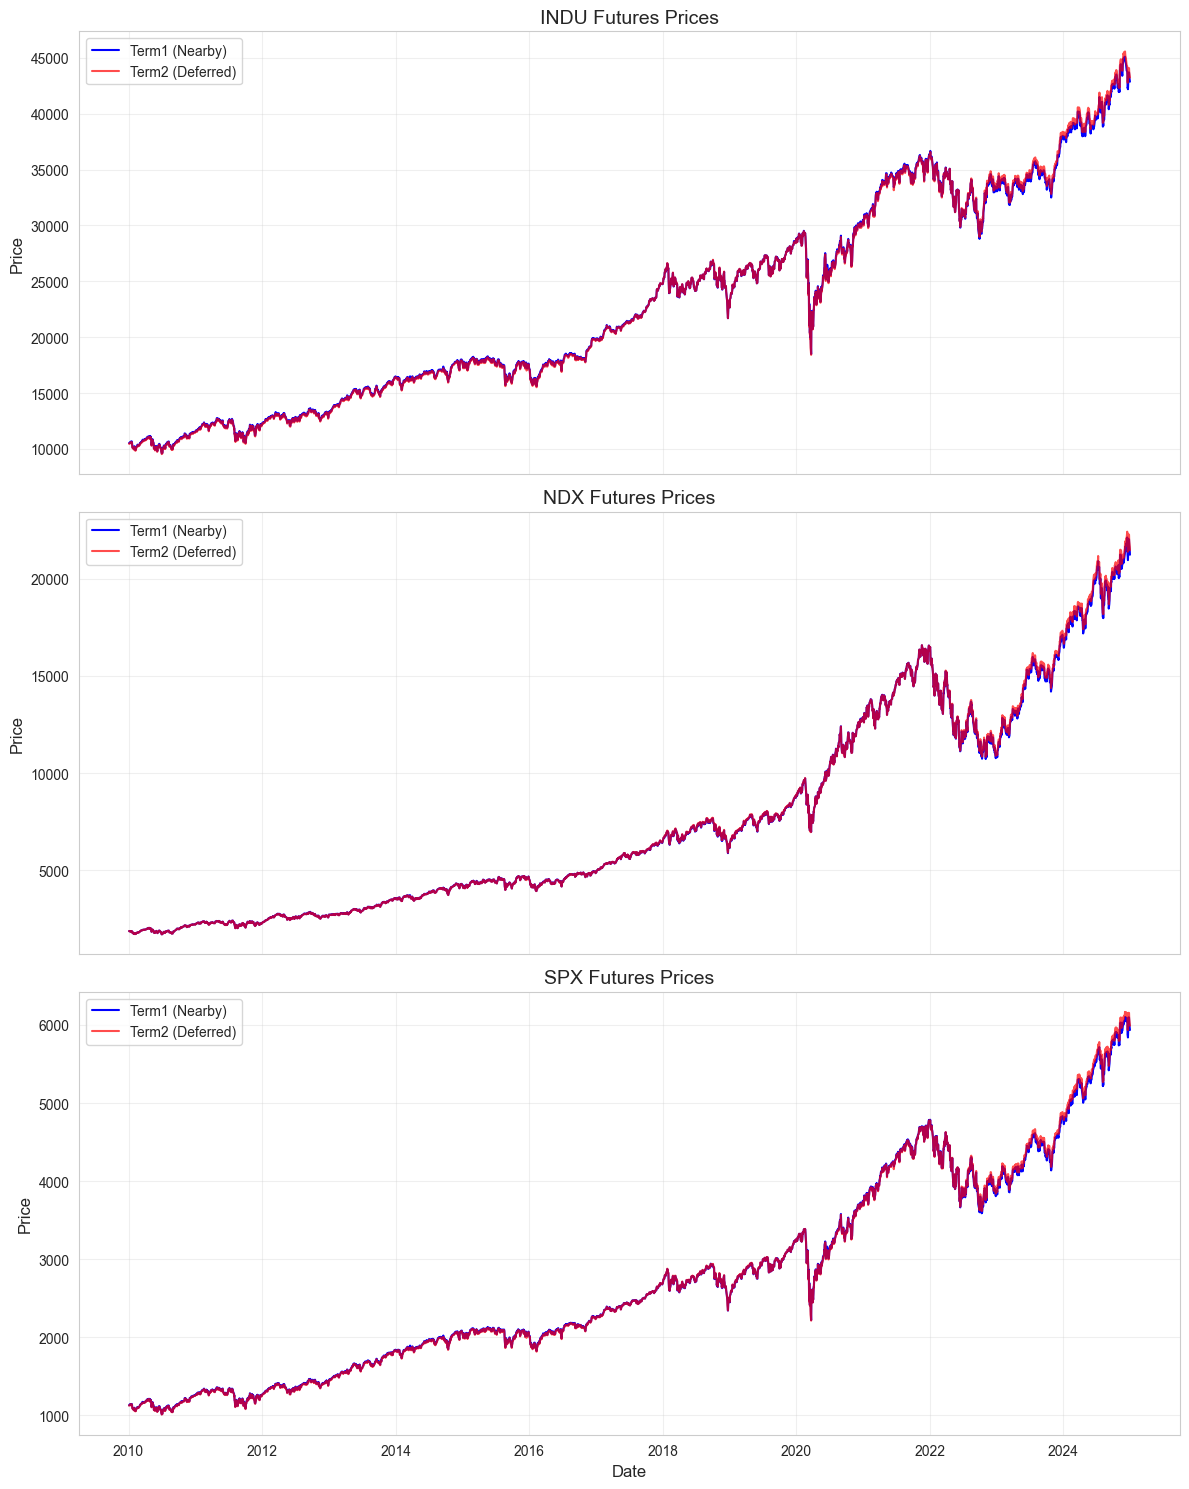

In [13]:
# Set up a multi-panel figure
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
indices = sorted(combined_spreads['Index'].unique())

for i, index in enumerate(indices):
    index_df = combined_spreads[combined_spreads['Index'] == index]
    
    # Plot Term1 and Term2 prices
    axes[i].plot(index_df['Date'], index_df['Term1_Futures_Price'], 'b-', label='Term1 (Nearby)')
    axes[i].plot(index_df['Date'], index_df['Term2_Futures_Price'], 'r-', alpha=0.7, label='Term2 (Deferred)')
    
    axes[i].set_title(f'{index} Futures Prices', fontsize=14)
    axes[i].set_ylabel('Price', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper left')

# Set common labels
axes[2].set_xlabel('Date', fontsize=12)
plt.tight_layout()

# Save the visualization
plt.savefig(OUTPUT_DIR / 'futures_prices_by_index.png', dpi=300)
plt.show()

## Integration with Forward Rate Calculations

The processed futures data is now ready for integration with the OIS rates data to calculate implied forward rates and arbitrage spreads.

The key outputs from this processing pipeline include:

1. **Individual Index Calendar Spreads**: Saved as CSV files (`SPX_Calendar_spread.csv`, `NDX_Calendar_spread.csv`, `INDU_Calendar_spread.csv`) in the `PROCESSED_DIR`.

2. **Combined Calendar Spreads**: Saved as `all_indices_calendar_spreads.csv` in the `PROCESSED_DIR`.

These files contain the following critical information:
- **Term1_Futures_Price** and **Term2_Futures_Price**: Prices for the nearby and deferred futures contracts
- **Term1_SettlementDate** and **Term2_SettlementDate**: Settlement dates for each contract
- **Term1_TTM** and **Term2_TTM**: Time-to-maturity in days

In the next step, these files will be used along with the processed OIS rates to calculate:
1. Futures-implied forward rates
2. OIS-implied forward rates
3. Equity spot-futures arbitrage spreads

The accurate processing of settlement dates and TTM is crucial for properly aligning the futures contracts with OIS rates and accumulating dividends over the correct time periods.
